# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

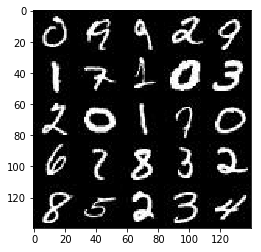

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

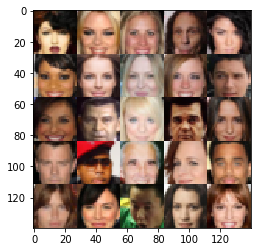

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False, alpha=0.01, training=False, keep_prob=0.7):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Define leaky relu so we don't need to write it every time
    def lrelu(tensor):
        return tf.maximum(alpha*tensor, tensor)
    
    # Define the batch normalized convolutional layer 
    def conv2d_batch_normalized(input_, depth, kernel_size, stride_size, activation):
        conv = tf.layers.conv2d(input_, depth, kernel_size, strides=stride_size, padding='same', use_bias=False,
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.layers.batch_normalization(conv, training=training)
        conv = activation(conv)
        if training:
            conv = tf.nn.dropout(conv, keep_prob)
        return conv
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Apply some convolutions
        conv1 = conv2d_batch_normalized(images, 256, 5, 2, lrelu) 
        conv2 = conv2d_batch_normalized(conv1, 512, 5, 2, lrelu)
        conv3 = conv2d_batch_normalized(conv2, 1024, 5, 2, lrelu)
        
        shape = conv3.get_shape().as_list()
        
        # Reshape, get logits and sigmoid
        flattened = tf.reshape(conv3, [-1, shape[1]*shape[2]*shape[3]])
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01, keep_prob=0.7):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Define leaky relu so we don't need to write it every time
    def lrelu(tensor):
        return tf.maximum(alpha*tensor, tensor)
    
    # Define the batch normalized transpose convolution
    def conv2d_trans_batch_normalized(input_, depth, kernel_size, stride_size, activation, padding='same'):
        conv = tf.layers.conv2d_transpose(input_, depth, kernel_size, strides=stride_size, padding=padding, use_bias=False,
                                          kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = activation(conv)
        if is_train:
            conv = tf.nn.dropout(conv, keep_prob)
        return conv
    
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        # Get a deep layer from the random input
        x = tf.layers.dense(z, 1024*3*3, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        x = tf.reshape(x, [-1, 3, 3, 1024])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = lrelu(x)
        if is_train:
            x = tf.nn.dropout(x, keep_prob=0.7)
        
        # Apply some transpose convolutions
        conv1 = conv2d_trans_batch_normalized(x, 512, 5, 2, lrelu) # 6x6x512
        conv2 = conv2d_trans_batch_normalized(conv1, 256, 4, 2, lrelu, 'valid') # 14x14x256
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 2, padding='same', # 28x28x(out_channel_dim)
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02)) 
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.01, smooth=0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_out = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=False, alpha=alpha)
    disc_fake_out, disc_fake_logits = discriminator(gen_out, reuse=True, alpha=alpha)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.ones_like(disc_real_logits)*(1-smooth),
        logits = disc_real_logits
    ))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.zeros_like(disc_fake_logits),
        logits = disc_fake_logits
    ))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.ones_like(disc_fake_logits),
        logits = disc_fake_logits
    ))
    
    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        gen_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return disc_opt, gen_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode,alpha=0.01):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha=alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         alpha = 0.01, print_every=50, show_every=500):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, width, height, channels = data_shape
    input_real, z_input, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, z_input, channels, alpha=alpha)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_n = 0           
            for batch_images in get_batches(batch_size):
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(disc_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                
                # Seen in slack: run generator twice to avoid the discriminator overpowering it
                sess.run(gen_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                
                if batch_n % print_every == 0:
                    dloss = disc_loss.eval({input_real: batch_images, z_input: z_batch, lr: learning_rate})
                    gloss = gen_loss.eval({input_real: batch_images, z_input: z_batch, lr: learning_rate})
                    print("Epoch: {}, Batch: {}, Disc. Loss: {:4f}, Gen. Loss: {:4f}".format(epoch_i+1, batch_n, dloss, gloss))
                
                if batch_n % show_every == 0:
                    show_generator_output(sess, 16, z_input, channels, data_image_mode, alpha=alpha)
                    
                batch_n += 1
            show_generator_output(sess, 16, z_input, channels, data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1, Batch: 0, Disc. Loss: 1.356429, Gen. Loss: 0.541638


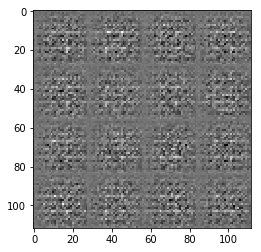

Epoch: 1, Batch: 50, Disc. Loss: 0.806809, Gen. Loss: 1.540841
Epoch: 1, Batch: 100, Disc. Loss: 0.838878, Gen. Loss: 0.666592
Epoch: 1, Batch: 150, Disc. Loss: 0.929616, Gen. Loss: 2.362863
Epoch: 1, Batch: 200, Disc. Loss: 0.731361, Gen. Loss: 1.152243
Epoch: 1, Batch: 250, Disc. Loss: 0.942359, Gen. Loss: 0.649088
Epoch: 1, Batch: 300, Disc. Loss: 0.645104, Gen. Loss: 1.773854
Epoch: 1, Batch: 350, Disc. Loss: 0.856796, Gen. Loss: 0.886441
Epoch: 1, Batch: 400, Disc. Loss: 0.871046, Gen. Loss: 2.482810
Epoch: 1, Batch: 450, Disc. Loss: 0.690232, Gen. Loss: 2.237849
Epoch: 1, Batch: 500, Disc. Loss: 0.825010, Gen. Loss: 0.789025


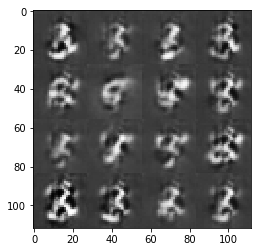

Epoch: 1, Batch: 550, Disc. Loss: 0.661601, Gen. Loss: 1.074265
Epoch: 1, Batch: 600, Disc. Loss: 0.674390, Gen. Loss: 1.200957
Epoch: 1, Batch: 650, Disc. Loss: 0.567331, Gen. Loss: 1.858436
Epoch: 1, Batch: 700, Disc. Loss: 0.663451, Gen. Loss: 1.084602
Epoch: 1, Batch: 750, Disc. Loss: 0.722053, Gen. Loss: 1.021611
Epoch: 1, Batch: 800, Disc. Loss: 0.640666, Gen. Loss: 0.994074
Epoch: 1, Batch: 850, Disc. Loss: 0.571936, Gen. Loss: 1.332294
Epoch: 1, Batch: 900, Disc. Loss: 0.564532, Gen. Loss: 2.813471
Epoch: 1, Batch: 950, Disc. Loss: 0.839702, Gen. Loss: 0.664733
Epoch: 1, Batch: 1000, Disc. Loss: 0.654182, Gen. Loss: 1.005706


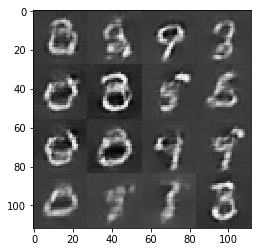

Epoch: 1, Batch: 1050, Disc. Loss: 0.539080, Gen. Loss: 2.546571
Epoch: 1, Batch: 1100, Disc. Loss: 0.588903, Gen. Loss: 1.190598
Epoch: 1, Batch: 1150, Disc. Loss: 0.518689, Gen. Loss: 2.043139
Epoch: 1, Batch: 1200, Disc. Loss: 1.069117, Gen. Loss: 4.020752
Epoch: 1, Batch: 1250, Disc. Loss: 0.495444, Gen. Loss: 2.747638
Epoch: 1, Batch: 1300, Disc. Loss: 0.958994, Gen. Loss: 0.853692
Epoch: 1, Batch: 1350, Disc. Loss: 0.432463, Gen. Loss: 1.780590
Epoch: 1, Batch: 1400, Disc. Loss: 0.590457, Gen. Loss: 1.053227
Epoch: 1, Batch: 1450, Disc. Loss: 0.416053, Gen. Loss: 2.042017
Epoch: 1, Batch: 1500, Disc. Loss: 0.428221, Gen. Loss: 1.881784


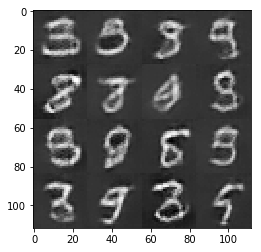

Epoch: 1, Batch: 1550, Disc. Loss: 0.542057, Gen. Loss: 1.237998
Epoch: 1, Batch: 1600, Disc. Loss: 0.467403, Gen. Loss: 2.517657
Epoch: 1, Batch: 1650, Disc. Loss: 0.419228, Gen. Loss: 1.990853
Epoch: 1, Batch: 1700, Disc. Loss: 0.448997, Gen. Loss: 2.301647
Epoch: 1, Batch: 1750, Disc. Loss: 1.242372, Gen. Loss: 5.567601
Epoch: 1, Batch: 1800, Disc. Loss: 0.469667, Gen. Loss: 1.353777
Epoch: 1, Batch: 1850, Disc. Loss: 0.410294, Gen. Loss: 3.231844


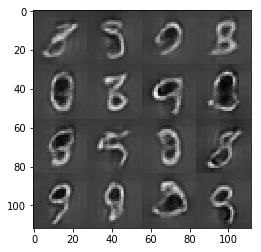

Epoch: 2, Batch: 0, Disc. Loss: 0.465568, Gen. Loss: 2.037051


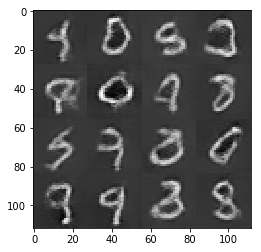

Epoch: 2, Batch: 50, Disc. Loss: 0.460463, Gen. Loss: 1.962142
Epoch: 2, Batch: 100, Disc. Loss: 0.320898, Gen. Loss: 2.164575
Epoch: 2, Batch: 150, Disc. Loss: 0.351426, Gen. Loss: 2.714983
Epoch: 2, Batch: 200, Disc. Loss: 0.512551, Gen. Loss: 1.395375
Epoch: 2, Batch: 250, Disc. Loss: 0.295835, Gen. Loss: 2.252977
Epoch: 2, Batch: 300, Disc. Loss: 0.826943, Gen. Loss: 0.787093
Epoch: 2, Batch: 350, Disc. Loss: 0.287938, Gen. Loss: 2.412971
Epoch: 2, Batch: 400, Disc. Loss: 0.340098, Gen. Loss: 3.469092
Epoch: 2, Batch: 450, Disc. Loss: 0.243039, Gen. Loss: 2.517848
Epoch: 2, Batch: 500, Disc. Loss: 0.351238, Gen. Loss: 1.718164


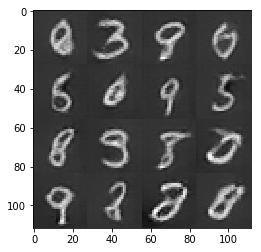

Epoch: 2, Batch: 550, Disc. Loss: 0.438902, Gen. Loss: 1.467948
Epoch: 2, Batch: 600, Disc. Loss: 0.302719, Gen. Loss: 2.410719
Epoch: 2, Batch: 650, Disc. Loss: 0.275886, Gen. Loss: 1.993642
Epoch: 2, Batch: 700, Disc. Loss: 0.348373, Gen. Loss: 1.837183
Epoch: 2, Batch: 750, Disc. Loss: 0.755724, Gen. Loss: 0.768490
Epoch: 2, Batch: 800, Disc. Loss: 0.424534, Gen. Loss: 1.626257
Epoch: 2, Batch: 850, Disc. Loss: 0.184599, Gen. Loss: 3.070713
Epoch: 2, Batch: 900, Disc. Loss: 1.288010, Gen. Loss: 7.365124
Epoch: 2, Batch: 950, Disc. Loss: 0.326051, Gen. Loss: 2.052027
Epoch: 2, Batch: 1000, Disc. Loss: 0.279004, Gen. Loss: 2.919387


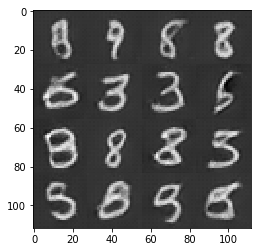

Epoch: 2, Batch: 1050, Disc. Loss: 0.565853, Gen. Loss: 4.386068
Epoch: 2, Batch: 1100, Disc. Loss: 0.303995, Gen. Loss: 2.652873
Epoch: 2, Batch: 1150, Disc. Loss: 0.403641, Gen. Loss: 1.947747
Epoch: 2, Batch: 1200, Disc. Loss: 0.303506, Gen. Loss: 3.269950
Epoch: 2, Batch: 1250, Disc. Loss: 0.286821, Gen. Loss: 2.178317
Epoch: 2, Batch: 1300, Disc. Loss: 0.222091, Gen. Loss: 3.085262
Epoch: 2, Batch: 1350, Disc. Loss: 0.347934, Gen. Loss: 3.388651
Epoch: 2, Batch: 1400, Disc. Loss: 0.307733, Gen. Loss: 2.925654
Epoch: 2, Batch: 1450, Disc. Loss: 0.329393, Gen. Loss: 3.899388
Epoch: 2, Batch: 1500, Disc. Loss: 0.212985, Gen. Loss: 2.969394


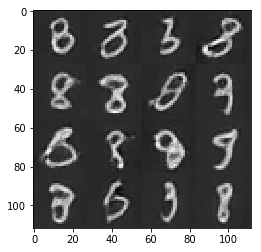

Epoch: 2, Batch: 1550, Disc. Loss: 0.257221, Gen. Loss: 2.987115
Epoch: 2, Batch: 1600, Disc. Loss: 0.235791, Gen. Loss: 3.514681
Epoch: 2, Batch: 1650, Disc. Loss: 0.211864, Gen. Loss: 3.238966
Epoch: 2, Batch: 1700, Disc. Loss: 0.424221, Gen. Loss: 1.986640
Epoch: 2, Batch: 1750, Disc. Loss: 1.033275, Gen. Loss: 5.091916
Epoch: 2, Batch: 1800, Disc. Loss: 0.293371, Gen. Loss: 2.577702
Epoch: 2, Batch: 1850, Disc. Loss: 0.158155, Gen. Loss: 3.623484


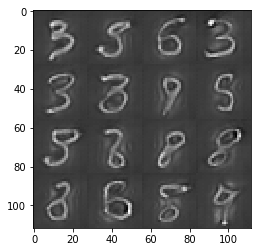

In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1, Batch: 0, Disc. Loss: 1.144059, Gen. Loss: 0.867355


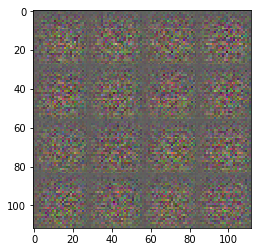

Epoch: 1, Batch: 50, Disc. Loss: 0.267941, Gen. Loss: 2.945505
Epoch: 1, Batch: 100, Disc. Loss: 0.149519, Gen. Loss: 3.195438
Epoch: 1, Batch: 150, Disc. Loss: 0.631160, Gen. Loss: 1.734726
Epoch: 1, Batch: 200, Disc. Loss: 0.255915, Gen. Loss: 2.157661
Epoch: 1, Batch: 250, Disc. Loss: 0.638058, Gen. Loss: 1.237786
Epoch: 1, Batch: 300, Disc. Loss: 0.627257, Gen. Loss: 1.528707
Epoch: 1, Batch: 350, Disc. Loss: 0.962013, Gen. Loss: 0.858225
Epoch: 1, Batch: 400, Disc. Loss: 0.946741, Gen. Loss: 0.836125
Epoch: 1, Batch: 450, Disc. Loss: 0.876837, Gen. Loss: 1.260259
Epoch: 1, Batch: 500, Disc. Loss: 1.092359, Gen. Loss: 1.075059


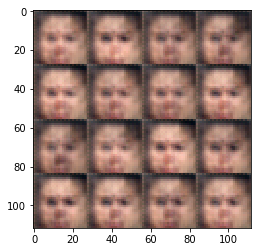

Epoch: 1, Batch: 550, Disc. Loss: 0.964559, Gen. Loss: 1.091886
Epoch: 1, Batch: 600, Disc. Loss: 1.063777, Gen. Loss: 1.020815
Epoch: 1, Batch: 650, Disc. Loss: 1.139815, Gen. Loss: 0.705677
Epoch: 1, Batch: 700, Disc. Loss: 0.885974, Gen. Loss: 1.003462
Epoch: 1, Batch: 750, Disc. Loss: 1.020287, Gen. Loss: 0.997470
Epoch: 1, Batch: 800, Disc. Loss: 1.246281, Gen. Loss: 0.779280
Epoch: 1, Batch: 850, Disc. Loss: 0.905384, Gen. Loss: 1.009748
Epoch: 1, Batch: 900, Disc. Loss: 1.244098, Gen. Loss: 0.581963
Epoch: 1, Batch: 950, Disc. Loss: 0.915946, Gen. Loss: 1.128945
Epoch: 1, Batch: 1000, Disc. Loss: 0.860003, Gen. Loss: 1.012885


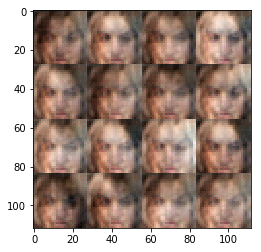

Epoch: 1, Batch: 1050, Disc. Loss: 1.270784, Gen. Loss: 0.716762
Epoch: 1, Batch: 1100, Disc. Loss: 1.058711, Gen. Loss: 1.010143
Epoch: 1, Batch: 1150, Disc. Loss: 1.293660, Gen. Loss: 0.761194
Epoch: 1, Batch: 1200, Disc. Loss: 1.323669, Gen. Loss: 0.835457
Epoch: 1, Batch: 1250, Disc. Loss: 1.274443, Gen. Loss: 0.770583
Epoch: 1, Batch: 1300, Disc. Loss: 1.232770, Gen. Loss: 0.845125
Epoch: 1, Batch: 1350, Disc. Loss: 1.314452, Gen. Loss: 0.608152
Epoch: 1, Batch: 1400, Disc. Loss: 1.242241, Gen. Loss: 0.993442
Epoch: 1, Batch: 1450, Disc. Loss: 1.336488, Gen. Loss: 0.752906
Epoch: 1, Batch: 1500, Disc. Loss: 1.061724, Gen. Loss: 0.876199


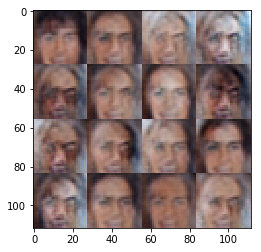

Epoch: 1, Batch: 1550, Disc. Loss: 0.922350, Gen. Loss: 0.851157
Epoch: 1, Batch: 1600, Disc. Loss: 1.091229, Gen. Loss: 0.927354
Epoch: 1, Batch: 1650, Disc. Loss: 1.116659, Gen. Loss: 0.812639
Epoch: 1, Batch: 1700, Disc. Loss: 1.685062, Gen. Loss: 0.373588
Epoch: 1, Batch: 1750, Disc. Loss: 1.105971, Gen. Loss: 1.287314
Epoch: 1, Batch: 1800, Disc. Loss: 1.274469, Gen. Loss: 0.732171
Epoch: 1, Batch: 1850, Disc. Loss: 1.460558, Gen. Loss: 0.599865
Epoch: 1, Batch: 1900, Disc. Loss: 1.093465, Gen. Loss: 0.819653
Epoch: 1, Batch: 1950, Disc. Loss: 1.183922, Gen. Loss: 0.868959
Epoch: 1, Batch: 2000, Disc. Loss: 1.026778, Gen. Loss: 1.014916


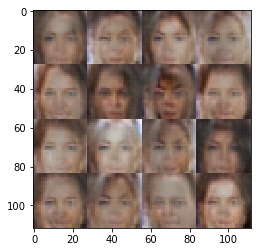

Epoch: 1, Batch: 2050, Disc. Loss: 1.739850, Gen. Loss: 0.484527
Epoch: 1, Batch: 2100, Disc. Loss: 0.856639, Gen. Loss: 1.134760
Epoch: 1, Batch: 2150, Disc. Loss: 1.146917, Gen. Loss: 0.835446
Epoch: 1, Batch: 2200, Disc. Loss: 1.230071, Gen. Loss: 0.762711
Epoch: 1, Batch: 2250, Disc. Loss: 1.002668, Gen. Loss: 0.877917
Epoch: 1, Batch: 2300, Disc. Loss: 1.186378, Gen. Loss: 0.773719
Epoch: 1, Batch: 2350, Disc. Loss: 1.148493, Gen. Loss: 0.827695
Epoch: 1, Batch: 2400, Disc. Loss: 1.139251, Gen. Loss: 0.709665
Epoch: 1, Batch: 2450, Disc. Loss: 1.143528, Gen. Loss: 0.717000
Epoch: 1, Batch: 2500, Disc. Loss: 1.306671, Gen. Loss: 0.635538


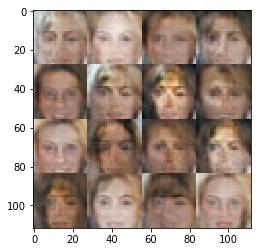

Epoch: 1, Batch: 2550, Disc. Loss: 1.119794, Gen. Loss: 0.716334
Epoch: 1, Batch: 2600, Disc. Loss: 1.080153, Gen. Loss: 0.762980
Epoch: 1, Batch: 2650, Disc. Loss: 0.960822, Gen. Loss: 0.927474
Epoch: 1, Batch: 2700, Disc. Loss: 1.050306, Gen. Loss: 0.846869
Epoch: 1, Batch: 2750, Disc. Loss: 1.250414, Gen. Loss: 0.952211
Epoch: 1, Batch: 2800, Disc. Loss: 1.153480, Gen. Loss: 0.766520
Epoch: 1, Batch: 2850, Disc. Loss: 1.125054, Gen. Loss: 0.702193
Epoch: 1, Batch: 2900, Disc. Loss: 0.943951, Gen. Loss: 0.960956
Epoch: 1, Batch: 2950, Disc. Loss: 1.011393, Gen. Loss: 0.922220
Epoch: 1, Batch: 3000, Disc. Loss: 1.185591, Gen. Loss: 1.028308


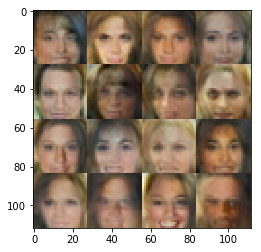

Epoch: 1, Batch: 3050, Disc. Loss: 1.102333, Gen. Loss: 0.780788
Epoch: 1, Batch: 3100, Disc. Loss: 1.257288, Gen. Loss: 0.726898
Epoch: 1, Batch: 3150, Disc. Loss: 1.293527, Gen. Loss: 1.024938
Epoch: 1, Batch: 3200, Disc. Loss: 1.096744, Gen. Loss: 0.873397
Epoch: 1, Batch: 3250, Disc. Loss: 1.081539, Gen. Loss: 0.863434
Epoch: 1, Batch: 3300, Disc. Loss: 0.994271, Gen. Loss: 1.208106
Epoch: 1, Batch: 3350, Disc. Loss: 0.880658, Gen. Loss: 1.320204
Epoch: 1, Batch: 3400, Disc. Loss: 1.094508, Gen. Loss: 0.981263
Epoch: 1, Batch: 3450, Disc. Loss: 1.265031, Gen. Loss: 0.714013
Epoch: 1, Batch: 3500, Disc. Loss: 1.111966, Gen. Loss: 0.766643


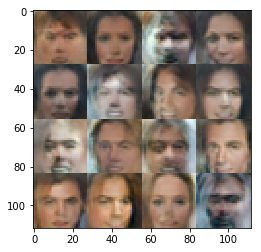

Epoch: 1, Batch: 3550, Disc. Loss: 1.167389, Gen. Loss: 0.970264
Epoch: 1, Batch: 3600, Disc. Loss: 0.981703, Gen. Loss: 1.049628
Epoch: 1, Batch: 3650, Disc. Loss: 1.030649, Gen. Loss: 0.889125
Epoch: 1, Batch: 3700, Disc. Loss: 1.011065, Gen. Loss: 1.197431
Epoch: 1, Batch: 3750, Disc. Loss: 1.012833, Gen. Loss: 1.529662
Epoch: 1, Batch: 3800, Disc. Loss: 0.945262, Gen. Loss: 1.542087
Epoch: 1, Batch: 3850, Disc. Loss: 1.122188, Gen. Loss: 0.706497
Epoch: 1, Batch: 3900, Disc. Loss: 1.034446, Gen. Loss: 1.037061
Epoch: 1, Batch: 3950, Disc. Loss: 1.052088, Gen. Loss: 1.335873
Epoch: 1, Batch: 4000, Disc. Loss: 0.996941, Gen. Loss: 0.797183


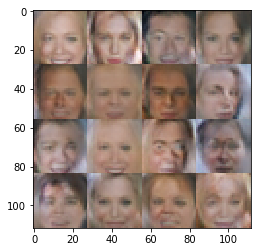

Epoch: 1, Batch: 4050, Disc. Loss: 1.118069, Gen. Loss: 0.702411
Epoch: 1, Batch: 4100, Disc. Loss: 1.021014, Gen. Loss: 0.938165
Epoch: 1, Batch: 4150, Disc. Loss: 1.203609, Gen. Loss: 1.026489
Epoch: 1, Batch: 4200, Disc. Loss: 1.022466, Gen. Loss: 0.727277
Epoch: 1, Batch: 4250, Disc. Loss: 0.849572, Gen. Loss: 1.150471
Epoch: 1, Batch: 4300, Disc. Loss: 1.161215, Gen. Loss: 0.604472
Epoch: 1, Batch: 4350, Disc. Loss: 0.972935, Gen. Loss: 1.105382
Epoch: 1, Batch: 4400, Disc. Loss: 1.027841, Gen. Loss: 1.062095
Epoch: 1, Batch: 4450, Disc. Loss: 1.042973, Gen. Loss: 1.082096
Epoch: 1, Batch: 4500, Disc. Loss: 1.271217, Gen. Loss: 0.689748


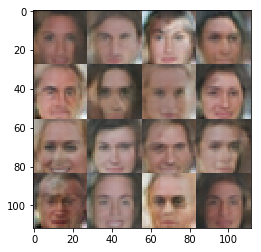

Epoch: 1, Batch: 4550, Disc. Loss: 1.060305, Gen. Loss: 1.131915
Epoch: 1, Batch: 4600, Disc. Loss: 0.929704, Gen. Loss: 1.286611
Epoch: 1, Batch: 4650, Disc. Loss: 1.129955, Gen. Loss: 1.271273
Epoch: 1, Batch: 4700, Disc. Loss: 1.080159, Gen. Loss: 0.844218
Epoch: 1, Batch: 4750, Disc. Loss: 1.078349, Gen. Loss: 0.767770
Epoch: 1, Batch: 4800, Disc. Loss: 1.035760, Gen. Loss: 0.966518
Epoch: 1, Batch: 4850, Disc. Loss: 0.965674, Gen. Loss: 0.841405
Epoch: 1, Batch: 4900, Disc. Loss: 0.955571, Gen. Loss: 0.926964
Epoch: 1, Batch: 4950, Disc. Loss: 1.381964, Gen. Loss: 0.648688
Epoch: 1, Batch: 5000, Disc. Loss: 1.198312, Gen. Loss: 0.764560


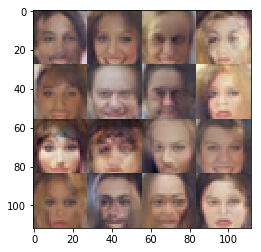

Epoch: 1, Batch: 5050, Disc. Loss: 0.986707, Gen. Loss: 0.952110
Epoch: 1, Batch: 5100, Disc. Loss: 1.109916, Gen. Loss: 0.665225
Epoch: 1, Batch: 5150, Disc. Loss: 1.180840, Gen. Loss: 1.080125
Epoch: 1, Batch: 5200, Disc. Loss: 0.968084, Gen. Loss: 1.211044
Epoch: 1, Batch: 5250, Disc. Loss: 1.081719, Gen. Loss: 0.933784
Epoch: 1, Batch: 5300, Disc. Loss: 0.869164, Gen. Loss: 1.065150
Epoch: 1, Batch: 5350, Disc. Loss: 0.864777, Gen. Loss: 1.310659
Epoch: 1, Batch: 5400, Disc. Loss: 1.029298, Gen. Loss: 0.949528
Epoch: 1, Batch: 5450, Disc. Loss: 1.009651, Gen. Loss: 1.072083
Epoch: 1, Batch: 5500, Disc. Loss: 0.973135, Gen. Loss: 1.035558


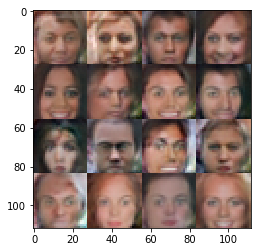

Epoch: 1, Batch: 5550, Disc. Loss: 0.909847, Gen. Loss: 1.053790
Epoch: 1, Batch: 5600, Disc. Loss: 0.744644, Gen. Loss: 1.661349
Epoch: 1, Batch: 5650, Disc. Loss: 1.024758, Gen. Loss: 0.774797
Epoch: 1, Batch: 5700, Disc. Loss: 0.850407, Gen. Loss: 0.968678
Epoch: 1, Batch: 5750, Disc. Loss: 0.888072, Gen. Loss: 1.131321
Epoch: 1, Batch: 5800, Disc. Loss: 1.047964, Gen. Loss: 0.785253
Epoch: 1, Batch: 5850, Disc. Loss: 0.941322, Gen. Loss: 1.314015
Epoch: 1, Batch: 5900, Disc. Loss: 0.861832, Gen. Loss: 0.925576
Epoch: 1, Batch: 5950, Disc. Loss: 0.874625, Gen. Loss: 1.059403
Epoch: 1, Batch: 6000, Disc. Loss: 0.979021, Gen. Loss: 0.947176


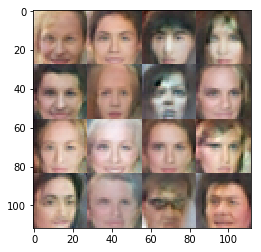

Epoch: 1, Batch: 6050, Disc. Loss: 1.052084, Gen. Loss: 0.683563
Epoch: 1, Batch: 6100, Disc. Loss: 0.959439, Gen. Loss: 0.948099
Epoch: 1, Batch: 6150, Disc. Loss: 0.905779, Gen. Loss: 0.836743
Epoch: 1, Batch: 6200, Disc. Loss: 0.914886, Gen. Loss: 1.035019
Epoch: 1, Batch: 6250, Disc. Loss: 0.913216, Gen. Loss: 1.248226
Epoch: 1, Batch: 6300, Disc. Loss: 0.994554, Gen. Loss: 0.911315


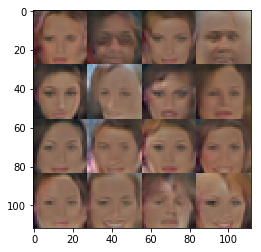

In [24]:
batch_size = 32
z_dim = 300
learning_rate = 0.0001
beta1 = 0.4
alpha=0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.